# Computer Vision 2025-2026 - NOVA FCT

### Assignment 1

**Authors**:
   - 75231 m.nowacki@campus.fct.unl.pt
   - 75267 k.kuznik@campus.fct.unl.pt


## Introduction

This report demonstrates a complete computer vision program for image grouping, white balancing, and feature matching. The system processes images through several stages: histogram-based similarity grouping, automatic white balancing, feature detection, description, and matching.

In [1]:
# Required libraries
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import os
import glob
import shutil
import re
import json
from IPython.display import display, Markdown

## Step 3: Resizing images

In [51]:
def resize_image(image, size=512):
    w, h = image.shape[:2]
    if h < w:
        new_h = size
        new_w = int(w * (size / h))
    else:
        new_w = size
        new_h = int(h * (size / w))
    
    resized = cv.resize(image, (new_w, new_h), interpolation=cv.INTER_AREA)
    return resized

(np.float64(-0.5), np.float64(511.5), np.float64(681.5), np.float64(-0.5))

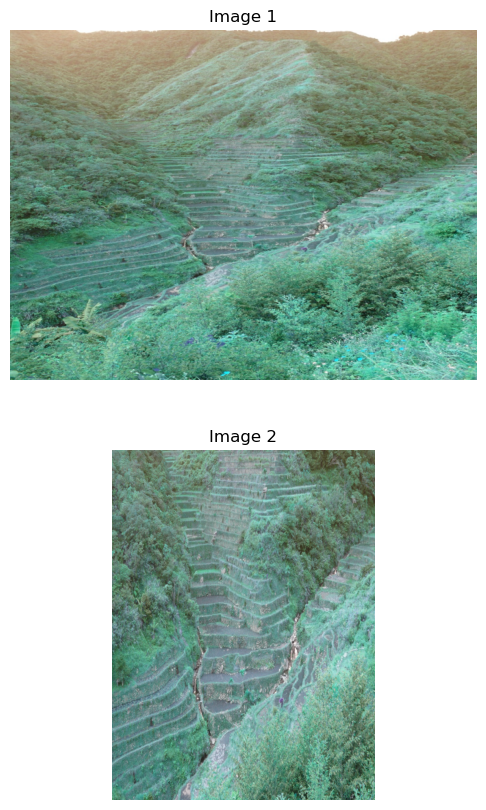

In [55]:
# Load and prepare two sample images

input_path = os.path.join("..", "input")

def load_and_prepare_images():
    img1 = cv.imread(os.path.join(input_path, "100300.jpg"), cv.IMREAD_COLOR)
    img2 = cv.imread(os.path.join(input_path, "100301.jpg"), cv.IMREAD_COLOR)
    img1 = resize_image(img1)
    img2 = resize_image(img2)
    return img1, img2

img1, img2 = load_and_prepare_images()

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Display images
axes[0].imshow(img1)
axes[0].set_title('Image 1')
axes[0].axis('off')

axes[1].imshow(img2)
axes[1].set_title('Image 2')
axes[1].axis('off')

## Step 4: Image Grouping Based on Histogram Similarity


The algorithm groups similar images by comparing their color histograms using the Bhattacharyya distance. This distance measures the similarity between two probability distributions (histograms).

We compute separate histograms for R, G, B channels, normalize them, and calculate the average distance across all channels.

In [28]:
def create_histograms(img):
    hist_r = cv.calcHist([img], [0], None, [256], [0, 256])
    hist_g = cv.calcHist([img], [1], None, [256], [0, 256])
    hist_b = cv.calcHist([img], [2], None, [256], [0, 256])
    cv.normalize(hist_r, hist_r)
    cv.normalize(hist_g, hist_g)
    cv.normalize(hist_b, hist_b)
    
    return hist_r, hist_g, hist_b

def histogram_distance(img1, img2):
    hist_r1, hist_g1, hist_b1 = create_histograms(img1)
    hist_r2, hist_g2, hist_b2 = create_histograms(img2)
    dist_r = cv.compareHist(hist_r1, hist_r2, cv.HISTCMP_BHATTACHARYYA)
    dist_g = cv.compareHist(hist_g1, hist_g2, cv.HISTCMP_BHATTACHARYYA)
    dist_b = cv.compareHist(hist_b1, hist_b2, cv.HISTCMP_BHATTACHARYYA)
    avg_dist = (dist_r + dist_g + dist_b) / 3
    return avg_dist


The histogram_distance function calculates the color similarity between two images by comparing their RGB histograms using the Bhattacharyya distance metric. This serves as the foundation for grouping visually similar images in the computer vision pipeline.

### Demonstration with Two Images


Histogram distance between images: 0.1116
Images are similar


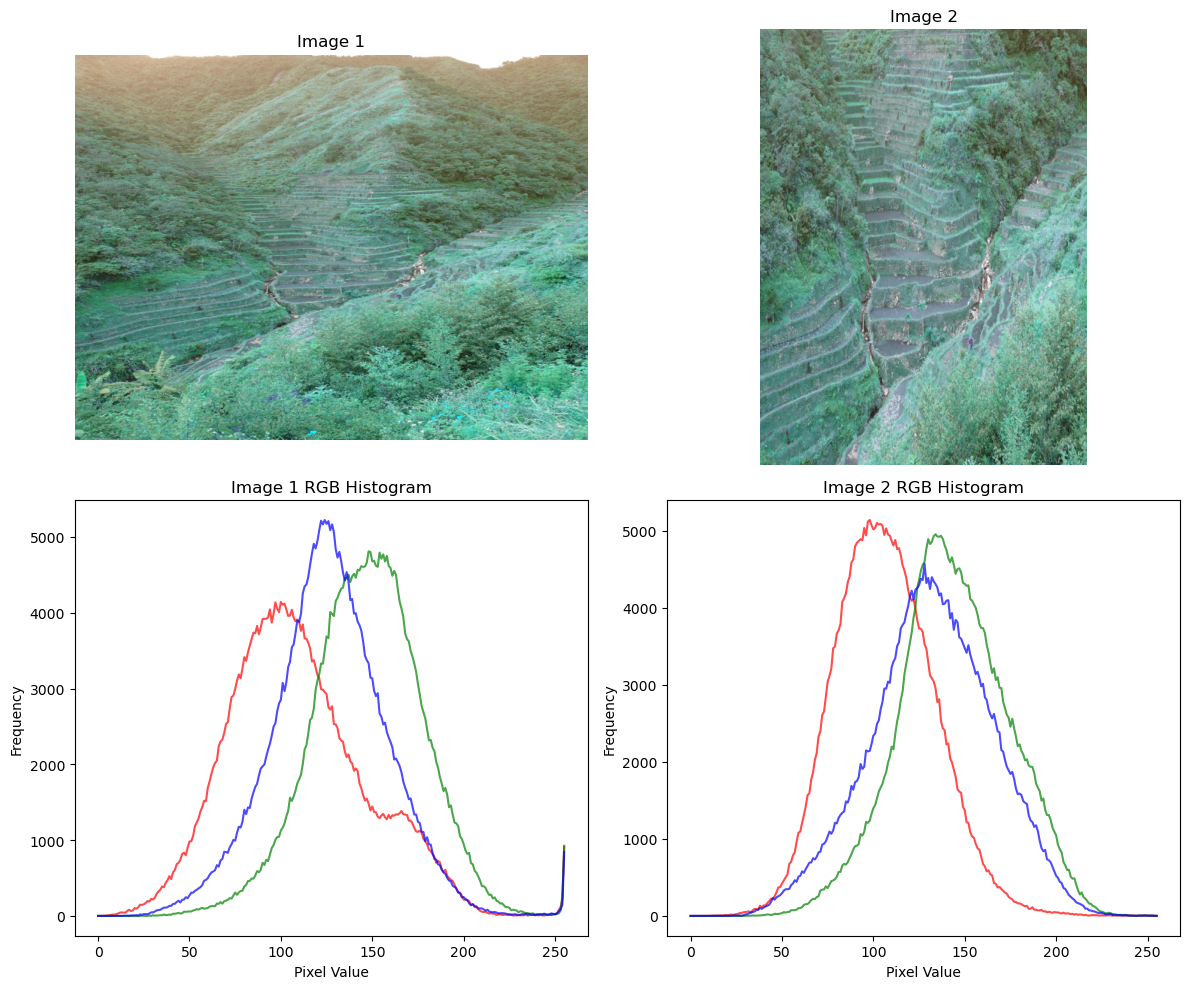

In [45]:
# Calculate histogram distance
dist = histogram_distance(img1, img2)
print(f"Histogram distance between images: {dist:.4f}")
print(f"Images are {'similar' if dist < 0.15 else 'different'}")

# Visualize images and their histograms
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Display images
axes[0, 0].imshow(img1)
axes[0, 0].set_title('Image 1')
axes[0, 0].axis('off')

axes[0, 1].imshow(img2)
axes[0, 1].set_title('Image 2')
axes[0, 1].axis('off')

# Display histograms
colors = ['r', 'g', 'b']
for i, color in enumerate(colors):
    hist1 = cv.calcHist([img1], [i], None, [256], [0, 256])
    hist2 = cv.calcHist([img2], [i], None, [256], [0, 256])
    axes[1, 0].plot(hist1, color=color, alpha=0.7)
    axes[1, 1].plot(hist2, color=color, alpha=0.7)

axes[1, 0].set_title('Image 1 RGB Histogram')
axes[1, 0].set_xlabel('Pixel Value')
axes[1, 0].set_ylabel('Frequency')

axes[1, 1].set_title('Image 2 RGB Histogram')
axes[1, 1].set_xlabel('Pixel Value')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Step 5: Automatic White Balancing


For each group of similar images, we compute an average RGB histogram and calculate the mean intensity for each channel. We then scale each channel to match the overall average intensity, effectively performing white balancing.

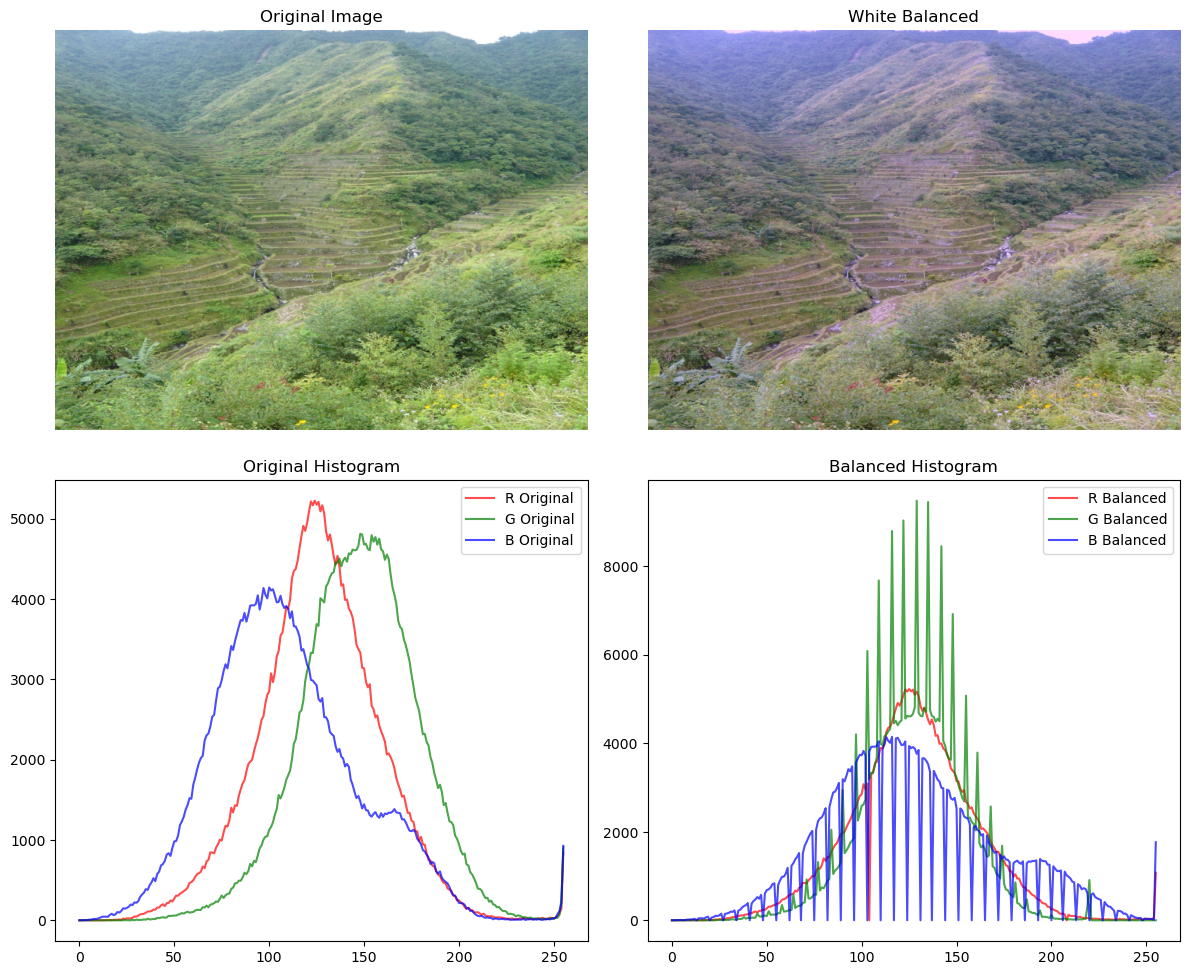

Original means - R: 126.6, G: 147.5, B: 109.3
Scale factors - R: 1.010, G: 0.866, B: 1.170


In [ ]:
def white_balancing():
    # Load an image with color cast
    sample_img = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
    
    # Apply white balancing (simplified version)
    img_float = sample_img.astype(np.float32)
    
    # Calculate mean for each channel
    mean_r = np.mean(img_float[:,:,0])
    mean_g = np.mean(img_float[:,:,1])
    mean_b = np.mean(img_float[:,:,2])
    
    # Target mean (average of all channels)
    target_mean = (mean_r + mean_g + mean_b) / 3.0
    
    # Calculate scale factors
    scale_r = target_mean / mean_r
    scale_g = target_mean / mean_g  
    scale_b = target_mean / mean_b
    
    # Apply white balance
    balanced = img_float * np.array([scale_r, scale_g, scale_b])
    balanced = np.clip(balanced, 0, 255).astype(np.uint8)
    
    # Display results
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    axes[0, 0].imshow(sample_img)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(balanced)
    axes[0, 1].set_title('White Balanced')
    axes[0, 1].axis('off')
    
    # Show histograms
    for i, color in enumerate(colors):
        hist_orig = cv.calcHist([sample_img], [i], None, [256], [0, 256])
        hist_bal = cv.calcHist([balanced], [i], None, [256], [0, 256])
        axes[1, 0].plot(hist_orig, color=color, alpha=0.7, label=f'{color.upper()} Original')
        axes[1, 1].plot(hist_bal, color=color, alpha=0.7, label=f'{color.upper()} Balanced')
    
    axes[1, 0].set_title('Original Histogram')
    axes[1, 0].legend()
    axes[1, 1].set_title('Balanced Histogram') 
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"Original means - R: {mean_r:.1f}, G: {mean_g:.1f}, B: {mean_b:.1f}")
    print(f"Scale factors - R: {scale_r:.3f}, G: {scale_g:.3f}, B: {scale_b:.3f}")

white_balancing()

## Step 6: Feature Point Detection

We use Shi-Tomasi corner detection (goodFeaturesToTrack) to find best feature points in images. These points are locations where there are significant intensity changes in both horizontal and vertical directions, making them stable for matching.

In [ ]:
def my_track_points(gray, num_features):
    corners = cv.goodFeaturesToTrack(gray, num_features, 0.01, 10)
    return corners.reshape(-1,2).astype(np.int32)

* image: input image in grey scale
* num_features: Maximum number of corners to return (here: 1000)
* quality_level: keeps corners that are at least x% as strong as the best one (here: 0.01, so 1%)
* minDistance: minimum Euclidean distance between detected corners. Ensures corners aren’t too close to each other (here: 10 pixels)

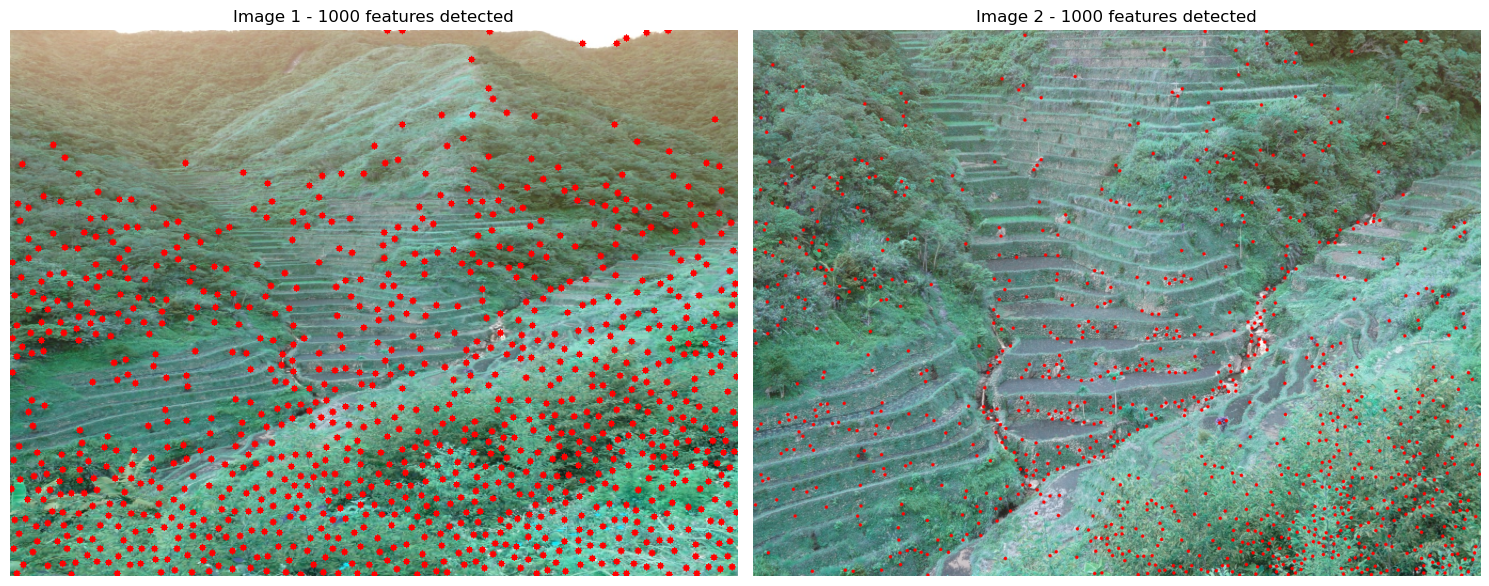

In [ ]:
def feature_detection():
    # Convert to grayscale
    gray1 = cv.cvtColor(img1, cv.COLOR_RGB2GRAY)
    gray2 = cv.cvtColor(img2, cv.COLOR_RGB2GRAY)
    
    # Detect features
    points1 = my_track_points(gray1, 1000)
    points2 = my_track_points(gray2, 1000)
    
    # Visualize detected points
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Draw points on images
    display_img1 = img1.copy()
    display_img2 = img2.copy()
    
    for point in points1:
        cv.circle(display_img1, tuple(point), 3, (255, 0, 0), -1)
    
    for point in points2:
        cv.circle(display_img2, tuple(point), 3, (255, 0, 0), -1)
    
    axes[0].imshow(display_img1)
    axes[0].set_title(f'Image 1 - {len(points1)} features detected')
    axes[0].axis('off')
    
    axes[1].imshow(display_img2)
    axes[1].set_title(f'Image 2 - {len(points2)} features detected')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

feature_detection()

## Feature Point Description with Rotation Invariance


We create a rotation-invariant descriptor by:

1. Finding dominant orientation using gradient histograms within a patch

2. Rotating the patch to canonical orientation

3. Creating normalized descriptor from resized patch pixels

This ensures the descriptor is invariant to image rotation.



Computed 41 descriptors
Descriptor dimension: (64,)
First descriptor values (first 10): [0.35794798 0.35172957 0.21997672 0.1554606  0.4558881  0.37349397
 0.48620293 0.55926937 0.54178005 0.37193942]


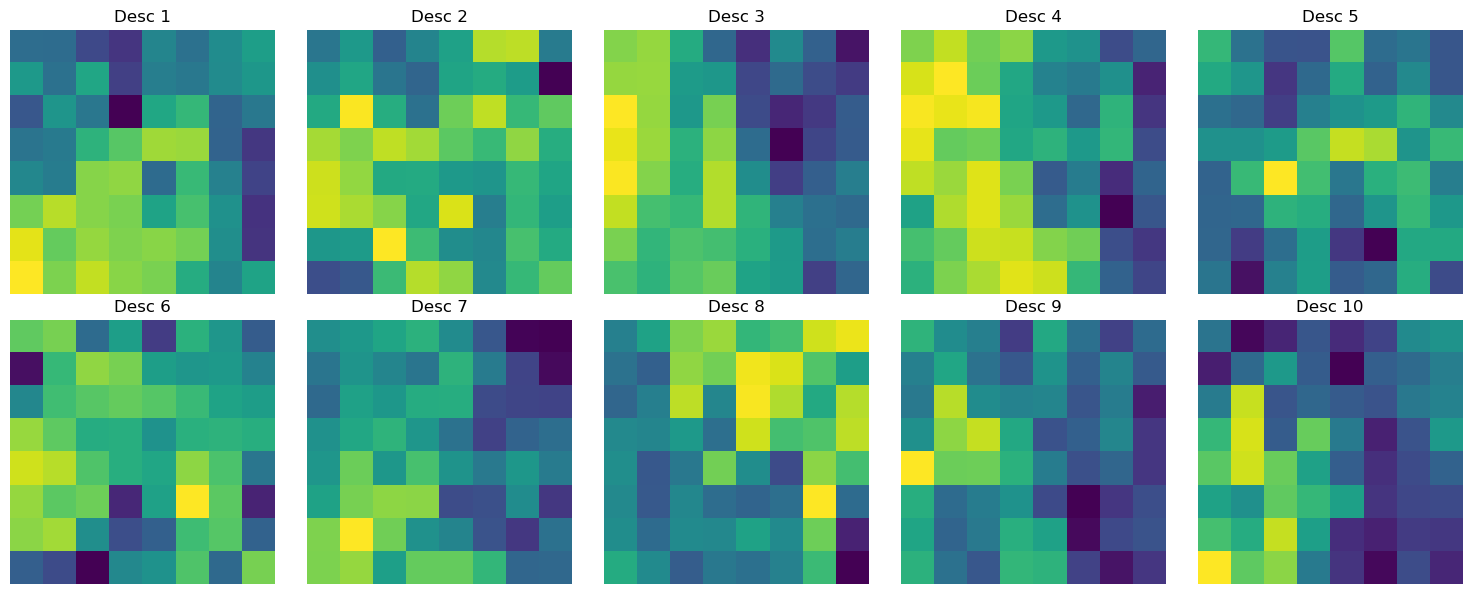

In [ ]:
def my_point_rotation(gray, point, patch_size=16):
    x, y = int(point[0]), int(point[1])
    half = patch_size // 2
    
    # Extract patch
    y1, y2 = max(y - half, 0), min(y + half, gray.shape[0])
    x1, x2 = max(x - half, 0), min(x + half, gray.shape[1])
    patch = gray[y1:y2, x1:x2]

    # Compute gradients
    grad_x = cv.Sobel(patch, cv.CV_64F, 1, 0, ksize=3)
    grad_y = cv.Sobel(patch, cv.CV_64F, 0, 1, ksize=3)

    # Orientation histogram
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    orientation = np.arctan2(grad_y, grad_x) * 180 / np.pi
    orientation = (orientation + 360) % 360

    # Weighted histogram
    hist, bin_edges = np.histogram(orientation, bins=36, range=(0, 360), weights=magnitude) # 10 degrees per 1 bin
    dominant_angle = bin_edges[np.argmax(hist)]
    
    return dominant_angle

def my_descriptor(gray, points, patch_size=40, small_size=8):
    descriptors = []
    h, w = gray.shape
    valid_points = []

    for point in points:
        x, y = int(point[0]), int(point[1])
        half = patch_size // 2

        # Check boundaries
        if (x - half < 0 or x + half >= w or 
            y - half < 0 or y + half >= h):
            continue

        # Get dominant orientation and rotate patch
        angle = my_point_rotation(gray, (x, y), half)
        M = cv.getRotationMatrix2D((x, y), -angle, 1.0)
        rotated = cv.warpAffine(gray, M, (w, h), flags=cv.INTER_LINEAR)

        # Extract and normalize patch
        y1, y2 = max(y - half, 0), min(y + half, h)
        x1, x2 = max(x - half, 0), min(x + half, w)
        patch = rotated[y1:y2, x1:x2]

        patch = patch.astype(np.float32)
        patch -= np.mean(patch)
        std = np.std(patch)
        if std > 1e-5:
            patch /= std

        # Create final descriptor
        small_patch = cv.resize(patch, (small_size, small_size), interpolation=cv.INTER_AREA)
        small_patch -= small_patch.min()
        if small_patch.max() > 0:
            small_patch /= small_patch.max()
        descriptor = small_patch.flatten()

        descriptors.append(descriptor)
        valid_points.append((float(x), float(y)))

    return np.array(descriptors, dtype=np.float32), valid_points

def demonstrate_descriptor_computation():
    gray1 = cv.cvtColor(img1, cv.COLOR_RGB2GRAY)
    
    # Detect a few points
    points = my_track_points(gray1, 50)
    
    # Compute descriptors
    descriptors, valid_points = my_descriptor(gray1, points)
    
    print(f"Computed {len(descriptors)} descriptors")
    print(f"Descriptor dimension: {descriptors[0].shape}")
    print(f"First descriptor values (first 10): {descriptors[0][:10]}")
    
    # Visualize descriptor patches
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    
    for i in range(min(10, len(descriptors))):
        # Reshape descriptor back to patch
        patch = descriptors[i].reshape(8, 8)
        axes[i].imshow(patch, cmap='viridis')
        axes[i].set_title(f'Desc {i+1}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

demonstrate_descriptor_computation()

## Step 7: Feature Matching


We use ratio test matching with custom distance function:

1. For each descriptor in image 1, find two nearest neighbors in image 2

2. Accept match if distance(best) / distance(second_best) < threshold

3. This eliminates ambiguous matches

Found 0 good matches


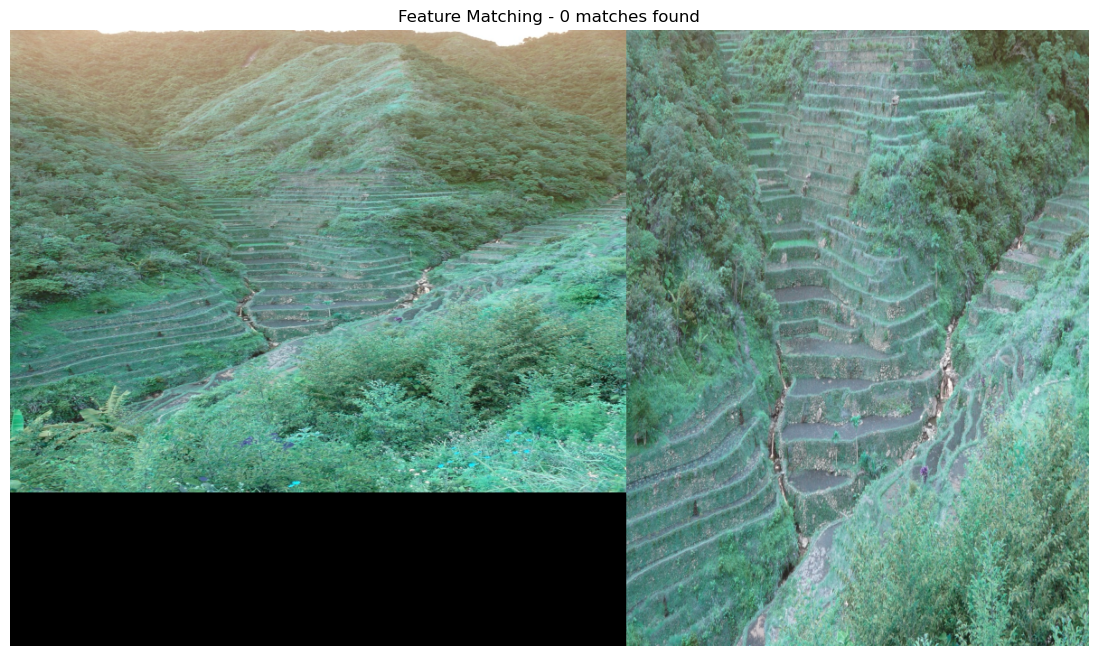

SIFT found 26 matches


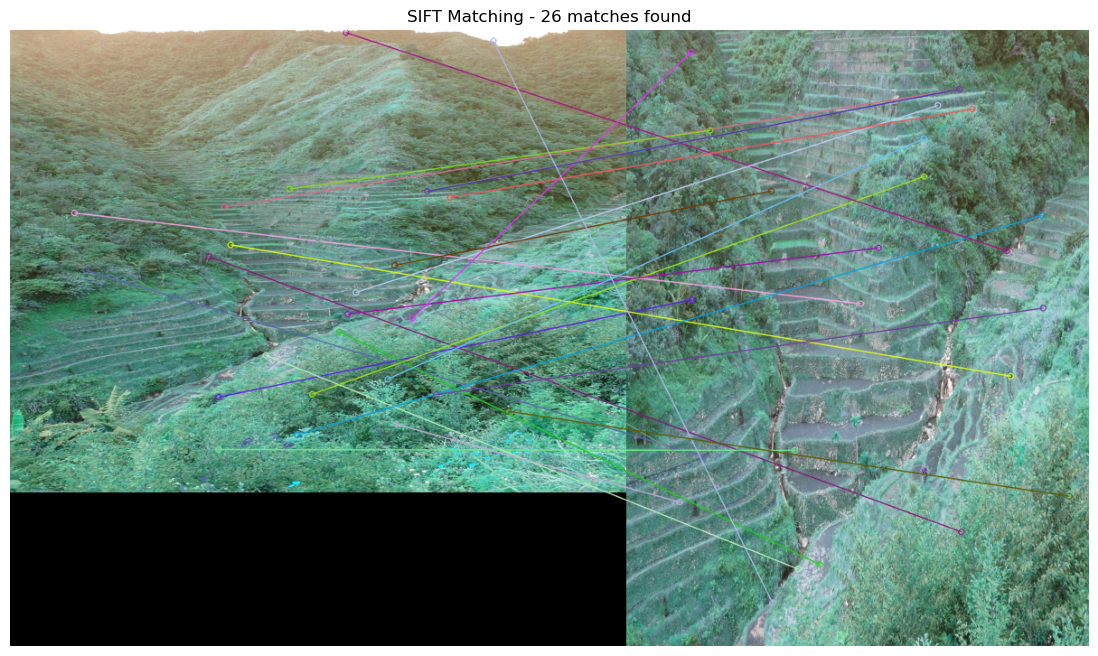

In [ ]:
from tp1 import sift_match

def my_distance(desc1, desc2):
    return np.linalg.norm(desc1 - desc2)

def my_match(descs1, descs2, ratio_threshold=0.75):
    good_matches = []

    for i, d1 in enumerate(descs1):
        # Compute distances to all descriptors in second image
        distances = [my_distance(d1, d2) for d2 in descs2]

        if len(distances) < 2:
            continue

        # Find two best matches
        sorted_idx = np.argsort(distances)
        best, second_best = distances[sorted_idx[0]], distances[sorted_idx[1]]

        # Apply ratio test
        if best / second_best < ratio_threshold:
            j = sorted_idx[0]
            good_matches.append(cv.DMatch(i, j, best))

    return good_matches

def feature_matching():
    gray1 = cv.cvtColor(img1, cv.COLOR_RGB2GRAY)
    gray2 = cv.cvtColor(img2, cv.COLOR_RGB2GRAY)
    
    # Detect and compute features for both images
    points1 = my_track_points(gray1, 1000)
    points2 = my_track_points(gray2, 1000)
    
    descs1, valid_points1 = my_descriptor(gray1, points1)
    descs2, valid_points2 = my_descriptor(gray2, points2)
    
    # Match features
    matches = my_match(descs1, descs2, ratio_threshold=0.75)
    
    print(f"Found {len(matches)} good matches")
    
    # Convert to KeyPoint for visualization
    kp1 = [cv.KeyPoint(x=pt[0], y=pt[1], size=10) for pt in valid_points1]
    kp2 = [cv.KeyPoint(x=pt[0], y=pt[1], size=10) for pt in valid_points2]
    
    # Draw matches
    matched_img = cv.drawMatches(
        cv.cvtColor(img1, cv.COLOR_RGB2BGR), kp1,
        cv.cvtColor(img2, cv.COLOR_RGB2BGR), kp2,
        matches, None,
        flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    
    plt.figure(figsize=(15, 8))
    plt.imshow(cv.cvtColor(matched_img, cv.COLOR_BGR2RGB))
    plt.title(f'Feature Matching - {len(matches)} matches found')
    plt.axis('off')
    plt.show()
    
    # Compare with SIFT
    sift_kp1, sift_kp2, sift_matches = sift_match(gray1, gray2)
    print(f"SIFT found {len(sift_matches)} matches")
    
    # Draw SIFT matches
    sift_matched_img = cv.drawMatches(
        cv.cvtColor(img1, cv.COLOR_RGB2BGR), sift_kp1,
        cv.cvtColor(img2, cv.COLOR_RGB2BGR), sift_kp2,
        sift_matches, None,
        flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    
    plt.figure(figsize=(15, 8))
    plt.imshow(cv.cvtColor(sift_matched_img, cv.COLOR_BGR2RGB))
    plt.title(f'SIFT Matching - {len(sift_matches)} matches found')
    plt.axis('off')
    plt.show()

feature_matching()

The description algorithm implemented by us is not working properly. We tried different approaches with no good effect. It is slower and less precise than the SIFT algorithm that is made ready in openCV. Hence we decided to use SIFT algorithm in our main program. 